### 05: Exploratory Data Analysis, Individual Level
##### Group 12:

##### Hannah Schmuckler, mmc4cv

##### Rob Schwartz, res7cd

At a minimum, the file should include a summary containing:
* Number of records
* Number of columns
* Statistical summary of response variable
* Statistical summary of potential predictor variables (if there are a large number of predictors, select the top 10)
* Note: Summarize categorical variables with counts and percentages for each level and summarize numerical variables with mean/quantiles/standard deviation.
* Include up to five helpful graphs

In [1]:
%%time
from pyspark.sql import SparkSession
from pyspark.sql import types as T
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import pandas as pd
import pyspark.sql.functions as f
from pyspark.sql.window import Window


import sys
spark = SparkSession.builder \
        .appName("project") \
        .getOrCreate()

sc = spark.sparkContext

CPU times: user 583 ms, sys: 490 ms, total: 1.07 s
Wall time: 6.1 s


### Read in data

#### Note: Our data was originally formatted in a 'tall' file forma with 9 columns:
* event_time
* event_type
* product_id
* category_code
* brand
* price
* user_id
* user_session

It was also significantly larger than the 3gb limitation for class. To address the size issue, we selected a random sample of individuals. 

All of the features in the dataset below have been engineered by us on an individual level, instead of the event-level data originally provided. 

In [2]:
full = spark.read.parquet("./processed_data/engineered_features.parquet")

In [3]:
full.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- T_total_spend: double (nullable = true)
 |-- total_spend: double (nullable = true)
 |-- total_events: long (nullable = true)
 |-- total_sessions: long (nullable = true)
 |-- avg_session_length: double (nullable = true)
 |-- sd_session_length: double (nullable = true)
 |-- avg_interactions_per_session: double (nullable = true)
 |-- sd_interactions_per_session: double (nullable = true)
 |-- max_interactions_per_session: long (nullable = true)
 |-- purchase_pct_of_total_events: double (nullable = true)
 |-- view_pct_of_total_events: double (nullable = true)
 |-- cart_pct_of_total_events: double (nullable = true)
 |-- avg_purchases_per_session: double (nullable = true)
 |-- sd_purchases_per_session: double (nullable = true)
 |-- cart_events: long (nullable = true)
 |-- purchase_events: long (nullable = true)
 |-- view_events: long (nullable = true)
 |-- sessions_with_purchase: long (nullable = true)
 |-- sessions_with_cart: long (nullable =

In [4]:
# Number of columns
len(full.schema)

23

##### A single record looks like this:

In [5]:
%%time
full.show(1, vertical=True)

-RECORD 0-------------------------------------------
 user_id                      | 416898622           
 T_total_spend                | 0.0                 
 total_spend                  | 1197.9500122070312  
 total_events                 | 14                  
 total_sessions               | 2                   
 avg_session_length           | 332.0               
 sd_session_length            | 165.46298679765212  
 avg_interactions_per_session | 7.0                 
 sd_interactions_per_session  | 5.656854249492381   
 max_interactions_per_session | 11                  
 purchase_pct_of_total_events | 0.14285714285714285 
 view_pct_of_total_events     | 0.6428571428571429  
 cart_pct_of_total_events     | 0.21428571428571427 
 avg_purchases_per_session    | 1.0                 
 sd_purchases_per_session     | 0.0                 
 cart_events                  | 3                   
 purchase_events              | 2                   
 view_events                  | 9             

In [6]:
%%time
## Note: We have not yet determined our best predictors, but perhaps looking at these outputs will help us.
for i in range(1,len(full.columns)):
    j = full.columns[i]
    full.select(j).summary().show()

+-------+------------------+
|summary|     T_total_spend|
+-------+------------------+
|  count|             34769|
|   mean|12973.819962659241|
| stddev| 68230.03060957523|
|    min|               0.0|
|    25%|               0.0|
|    50%|               0.0|
|    75%|               0.0|
|    max| 4302172.777099609|
+-------+------------------+

+-------+------------------+
|summary|       total_spend|
+-------+------------------+
|  count|             34769|
|   mean|1457.3151733480454|
| stddev| 5645.505135890194|
|    min|0.9700000286102295|
|    25%|132.56999969482422|
|    50%| 288.2699890136719|
|    75%|  847.719970703125|
|    max| 99683.20916748047|
+-------+------------------+

+-------+------------------+
|summary|      total_events|
+-------+------------------+
|  count|             34769|
|   mean|  75.2022491299721|
| stddev|195.75084785756843|
|    min|                 1|
|    25%|                11|
|    50%|                25|
|    75%|                61|
|    max|   

There are additional features that are not yet fully integrated in our engineered features. Here is our original dataset so we can do some basic summary of things like product_id, brand and individual price. 

Note that period is a feature that we added after filtering the data to easily keep track of which month a given row is from. This is the month 1 dataset, where all our predictors will come from. The month 2 dataset (not in this document) has been aggregated above to produce our response variable. 

In [7]:
m1 = spark.read.parquet('./processed_data/month_01_filtered.parquet')

In [8]:
m1.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_session: string (nullable = true)



In [9]:
# Number of columns
len(m1.schema)

9

In [10]:
m1.select('event_type').distinct().count()

3

In [11]:
%%time
m1.select('product_id').distinct().count()
# There are 181,283 different products. 

CPU times: user 999 µs, sys: 2.01 ms, total: 3.01 ms
Wall time: 962 ms


92764

In [12]:
%%time
m1.select('category_code').distinct().count()
# There are 136 different categories

CPU times: user 1.2 ms, sys: 1.2 ms, total: 2.4 ms
Wall time: 593 ms


136

In [13]:
%%time
m1.select('brand').distinct().count()
# There are 4770 different brands

CPU times: user 2.64 ms, sys: 386 µs, total: 3.02 ms
Wall time: 589 ms


3897

In [14]:
m1.describe('price').show()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|          1598123|
|   mean|274.1030332248468|
| stddev|337.0041004688195|
|    min|              0.0|
|    max|          2574.07|
+-------+-----------------+



In [15]:
%%time
m1.select('user_session').distinct().count()
# There are 2697902 different user sessions

CPU times: user 2.17 ms, sys: 1.15 ms, total: 3.32 ms
Wall time: 622 ms


268381

### Visualization

##### Response Variable: Spend in month 2

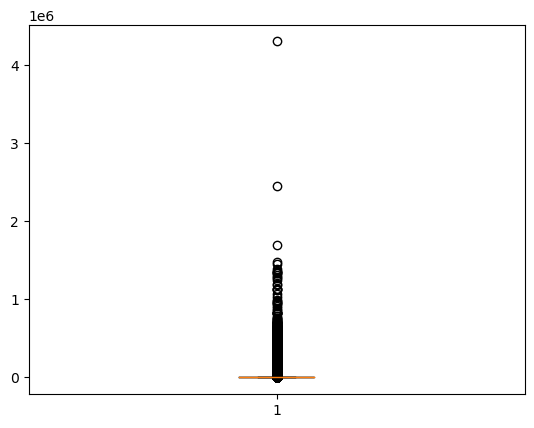

In [16]:
response = full.select('T_total_spend').toPandas()['T_total_spend']
plt.boxplot(response)
plt.show()

That's essentially useless, we're obviously going to have to do some transformation on our response and remove outliers, but here's a histogram:

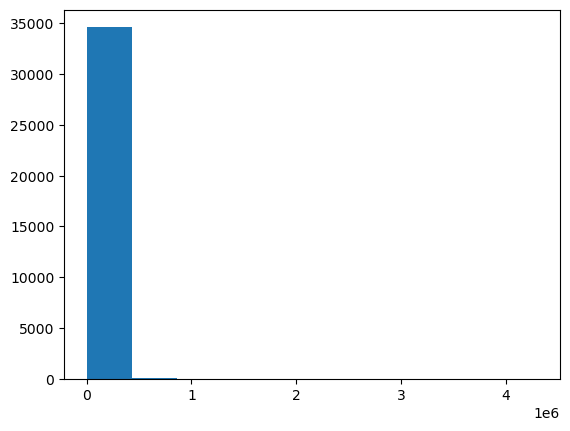

In [17]:
plt.hist(response)
plt.show()

### Just to get an idea of how common purchases are...

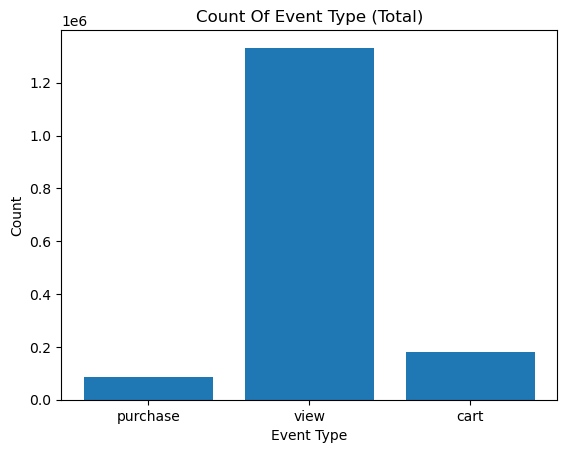

In [18]:
events = m1.groupBy('event_type').count()
x = events.select('event_type').toPandas()['event_type']
y = events.select('count').toPandas()['count']

plt.bar(x, y)
plt.title("Count Of Event Type (Total)")
plt.xlabel("Event Type")
plt.ylabel("Count")


plt.show()

#### To get an idea of the variation in behavior...standard deviation of interactions per session

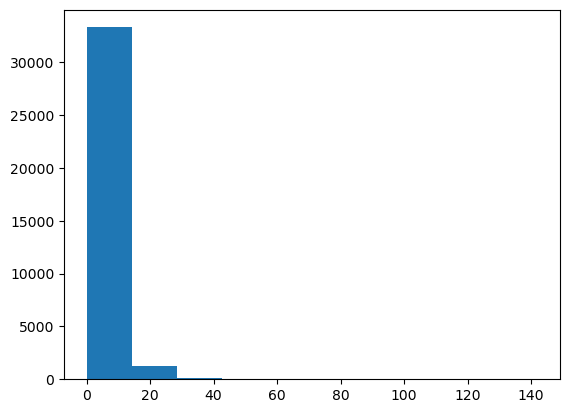

In [19]:
response = full.select('sd_interactions_per_session').toPandas()['sd_interactions_per_session']
plt.hist(response)
plt.show()

#### Average Purchases Per Session

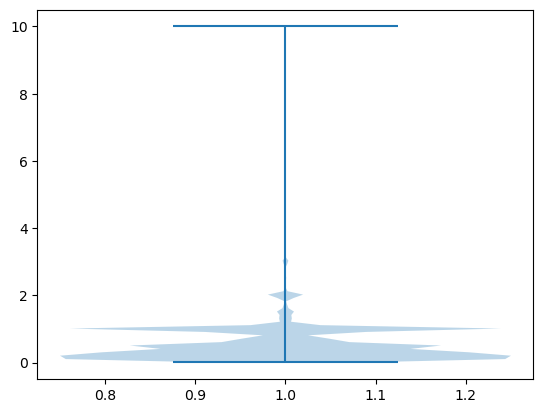

In [20]:
response = full.select('avg_purchases_per_session').toPandas()['avg_purchases_per_session']
plt.violinplot(response)
plt.show()
